# Predicting Customer Satisfaction - Logistic Regression

---

## Introduction

This **Logistic Regression** analysis examines open-text reviews from Intel's call center surveys spanning 2018 to 2021. By leveraging natural language processing techniques, the study aims to predict customer satisfaction for callers. Developing such a model can help Intel improve satisfaction scores and reduce future expenses associated with manual analysis. Moreover, this model may serve as a foundation for more advanced and effective analytical tools.

## Hypothesis for Call Center Customer Satisfaction Prediction

### Null Hypothesis (H₀)
There is no significant relationship between Intel's call center customer reviews and customer satisfaction.

### Alternative Hypothesis (H₁)
There is a significant relationship between Intel's call center customer reviews and customer satisfaction, meaning that call center reviews have a significant impact on predicting whether a customer is satisfied or not.

---

## Data Source and Methodology

- **Data Sources:**  
  The dataset is sourced from the Intel website surveys developed by ONR.
  
- **Methodology:**  
    This analysis utilizes **logistic regression** to evaluate the relationship between customer call center reviews and their effectiveness in predicting overall satisfaction.

---

## Practical Applications  

This analysis is particularly valuable for **call center managers and customer experience teams** looking to enhance service quality and customer satisfaction. It offers:  

- **Actionable Insights:** The classification model may identify key factors influencing customer satisfaction and areas for improvement.  
- **Strategic Guidance:** Provides a data-driven framework for optimizing call center operations, reducing churn, and improving overall service efficiency.


Table of Contents
=================

1. [Importing the Preprocessed Data](#Importing-the-Preprocessed-Data)
2. [Train & Test Data](#Train-&-Test-Data)
3. [Model Training, Testing, & Evaluation](#Model-Training,-Testing,-&-Evaluation)
   - [Model Training & Evaluation](#Model-Training-&-Evaluation)
   - [Model Testing & Evaluation](#Model-Training-&-Evaluation)
   - [Model Finalization](#Model-Finalization)

In [122]:
import fasttext
import fasttext.util

import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings
warnings.filterwarnings("ignore")

import os
import sys

from pickle import dump 
from pickle import load
from typing import Any, List, Tuple, Union

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from transformers import BertTokenizer, BertModel
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, classification_report, f1_score

from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

import re
from IPython.core.display import display, HTML

import spacy
import gensim
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as API
from gensim.models import FastText
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')

import random

import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory (the directory of the running script)
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, "NLP_Functions")))
from NLP_Functions.Preprocessing_Functions import Preprocessing, TextProcessingPipeline

sys.path.append(os.path.abspath(os.path.join(current_dir, "Classification_Functions")))
from Classification_Functions.Classification_Metrics_Functions import Metrics
from Classification_Functions.Preprocessing_Functions import Preprocessing

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\owner\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\owner\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Importing the Preprocessed Data

---

In [75]:
# Import the data frame from the logistic regression EDA
doc = pd.read_csv('Preprocessed_Data/Preprocessed_Data.csv')
doc = doc.loc[doc['review_length'] >= 25].reset_index(drop=True)

doc['SAT_Target'] = np.where(
    (doc['SAT'] == 'Dissatisfied') | (doc['SAT'] == 'Neutral'), 
    1,
    0
)

doc.info()
doc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6409 entries, 0 to 6408
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   SAT                      6409 non-null   object
 1   MTranslation2            6409 non-null   object
 2   processed_MTranslation2  6409 non-null   object
 3   review_length            6409 non-null   int64 
 4   SAT_Target               6409 non-null   int32 
dtypes: int32(1), int64(1), object(3)
memory usage: 225.4+ KB


,SAT,MTranslation2,processed_MTranslation2,review_length,SAT_Target
0,Satisfied,Our support staff was very courteous. The with...,support staff courteous withdrawal defective o...,30,0
1,Satisfied,It's actually easy to chip production & proces...,actually easy chip production processor know h...,26,0
2,Satisfied,Improve the technical level and product profic...,improve technical level product proficiency te...,40,0
3,Satisfied,In this instance I contacted support for advic...,instance contact support advice potential driv...,57,0
4,Neutral,Technical support could be more responsive. I ...,technical support could responsive often wait ...,28,1


After multiple iterations, the model struggled with short-text reviews, performing significantly better on reviews containing at least **25 words**.  

While further refinements could improve performance, this model serves **as a strong starting point** given time constraints.  

Additionally, with neutral reviews accounting for only **5% of the data**, merging them with the **dissatisfied** category improved predictive accuracy. As observed in the EDA, both **dissatisfied and neutral reviews** tend to be longer on average. That being said, **Intel could benefit from proactively addressing any customers who are not fully satisfied**. By being able to target the "unsatisfied" group through the model could help Intel with this inititative.

## Train & Test Data 

---

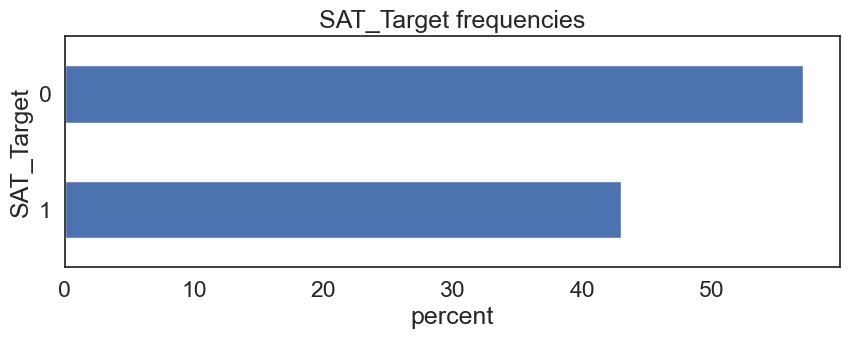

Counts
SAT_Target
0             3666
1             2743
Name: count, dtype: int64


Percentages
SAT_Target
0             57.200811
1             42.799189
Name: proportion, dtype: float64


In [79]:
# Retaine missed_playoffs in a separate data frame
target_df = doc[['SAT_Target']].astype(str)

# Satisfaction frequencies
Preprocessing.cat_univariate_freq(
    df = target_df, 
    length = 3, 
    width = 10, 
    col_start = 0, 
    col_end = 1, 
    font = 1.5
)

# Calculate the averages accross both classifications
print('Counts')
print(target_df.value_counts())
print('\n')
print('Percentages')
print(target_df.value_counts(normalize=True) * 100)


             <------------------------------------ Train Data ------------------------------------>             



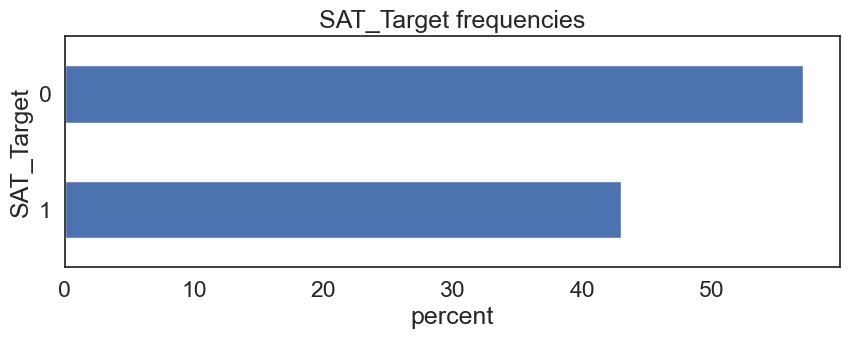

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4486 entries, 0 to 4485
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   processed_MTranslation2  4486 non-null   object
 1   SAT_Target               4486 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 52.7+ KB


,processed_MTranslation2,SAT_Target
0,warranty module support site allow create norm...,0
1,bogdan great pain understand problem fix ultim...,0
2,wait courier return processor question write l...,0



             <------------------------------------ Test Data ------------------------------------>              



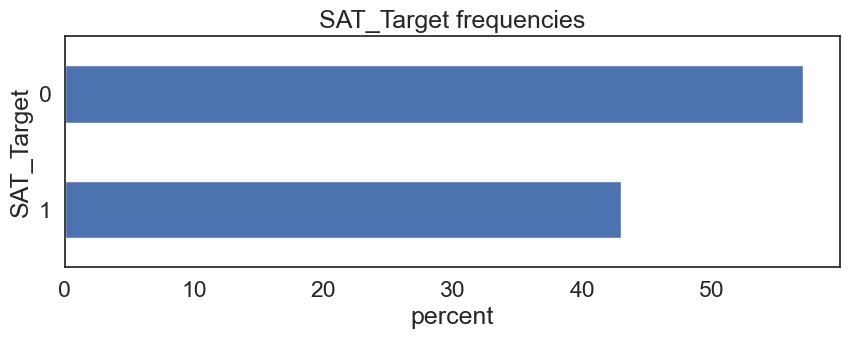

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1923 entries, 0 to 1922
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   processed_MTranslation2  1923 non-null   object
 1   SAT_Target               1923 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 22.7+ KB


,processed_MTranslation2,SAT_Target
0,hard drive stock replacement advance hard disk...,0
1,initial help request debian base driver suppor...,1
2,ask person telephone support put cpu inspectio...,0


In [80]:
# Split the data into an 80/20 train and test stratified split by missed_playoffs frequency
split = StratifiedShuffleSplit(
    n_splits = 1, 
    test_size = 0.3, 
    random_state = 0
) 

for train_index, test_index in split.split(doc, doc['SAT_Target']):
    strat_train_set = doc.loc[train_index] 
    strat_test_set = doc.loc[test_index]

train_temp = strat_train_set[['SAT_Target']].astype(str).reset_index(drop=True)
strat_train_set = strat_train_set[['processed_MTranslation2','SAT_Target']].reset_index(drop=True)

test_temp = strat_test_set[['SAT_Target']].astype(str).reset_index(drop=True)
strat_test_set = strat_test_set[['processed_MTranslation2','SAT_Target']].reset_index(drop=True)

print(
    "\n",
    "<------------------------------------ Train Data ------------------------------------>".center(
        110
    ),
    "\n",
)
Preprocessing.cat_univariate_freq(
    df = train_temp, 
    length = 3, 
    width = 10, 
    col_start = 0, 
    col_end = 1, 
    font = 1.5
)

strat_train_set.info()
display(strat_train_set.head(3))

print(
    "\n",
    "<------------------------------------ Test Data ------------------------------------>".center(
        110
    ),
    "\n",
)
Preprocessing.cat_univariate_freq(
    df = test_temp, 
    length = 3, 
    width = 10, 
    col_start = 0, 
    col_end = 1, 
    font = 1.5
)

strat_test_set.info()
display(strat_test_set.head(3))

Given the significant class imbalance, **stratified train-test splitting** was applied to preserve the original class proportions and ensure consistency during model training.  

After filtering reviews to retain only those with **≥ 25 words**, the dataset naturally became more balanced. This aligns with EDA findings, where **satisfied reviews were statistically shorter** compared to other categories.  

By implementing **both a stratified split and a word-length threshold**, the model is expected to be **more robust, improving both accuracy and efficiency**.  

## Model Training, Testing, & Evaluation

---

### Model Training & Evaluation

In [84]:
# Vectorize Text Data
vectorizer = TfidfVectorizer()

# Ensure 'processed_MTranslation2' is a Series (not a DataFrame)
X_train = vectorizer.fit_transform(strat_train_set['processed_MTranslation2'])
y_train = strat_train_set['SAT_Target']

# K-Fold Cross-Validation
k_fold = StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.30)

logit_model = LogisticRegression(
    # multi_class='multinomial',
    class_weight='balanced',
    solver="saga",
    max_iter=2000,
    n_jobs=-1
)

# Store results
f1_scores = []

print('\nTraining XGBoost Model with K-Fold Cross-Validation:\n')

# Train & Evaluate the Model using K-Fold
for fold, (train_index, test_index) in enumerate(k_fold.split(X_train, y_train), 1):
    # Split into training & testing sets
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train logistic regression model
    logit_model.fit(X_train_fold, y_train_fold)

    # Make predictions
    y_pred = logit_model.predict(X_test_fold)

    # Compute accuracy
    f1 = f1_score(y_test_fold, y_pred, average='weighted')
    f1_scores.append(f1)

    print(f"Fold {fold}: F1 = {f1:.4f}")
    print(classification_report(y_test_fold, y_pred))

# Compute Average Accuracy
avg_f1 = sum(f1_scores) / len(f1_scores)
print(f"\nAverage f1 across 10 folds: {avg_f1:.4f}")

logit_model.fit(X_train, y_train)

# Final Model Evaluation
y_pred_train = logit_model.predict(X_train)
print("\nFinal Classification Report:\n", classification_report(y_train, y_pred_train))


Training XGBoost Model with K-Fold Cross-Validation:

Fold 1: F1 = 0.7438
              precision    recall  f1-score   support

           0       0.78      0.77      0.78       770
           1       0.70      0.70      0.70       576

    accuracy                           0.74      1346
   macro avg       0.74      0.74      0.74      1346
weighted avg       0.74      0.74      0.74      1346

Fold 2: F1 = 0.7428
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       770
           1       0.67      0.77      0.72       576

    accuracy                           0.74      1346
   macro avg       0.74      0.75      0.74      1346
weighted avg       0.75      0.74      0.74      1346

Fold 3: F1 = 0.7555
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       770
           1       0.70      0.74      0.72       576

    accuracy                           0.75      1346
   macro avg 

The model was trained using **k-fold cross-validation** to evaluate its ability to handle unseen data and assess its generalizability. Across all folds, the model performed **moderately well**, achieving an average **F1 score of 0.74**.  

The observed **class imbalance** (where *dissatisfied + neutral = unsatisfied*) may have contributed to the model struggling more with predicting **unsatisfied customers** compared to **satisfied customers**. However, when analyzing **precision and recall** across all folds, we see a **moderate balance in predictive power**.  

Interestingly, when the model was **fully trained on the entire training dataset**, its predictive performance across all metrics **improved significantly with a weighted f1 score of 0.89**. This suggests a **lack of generalization** to unseen data. Further improvements could be made by **training on more data** or exploring **more advanced modeling techniques** to enhance performance.

### Model Testing & Evaluation

In [86]:
# Prepare your text data and target from the training DataFrame
X_test = strat_test_set['processed_MTranslation2']
X_test = vectorizer.transform(X_test)
y_test = strat_test_set['SAT_Target']

y_pred_test = logit_model.predict(X_test)

# Final Model Evaluation
print("\nFinal Classification Report:\n", classification_report(y_test, y_pred_test))


Final Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.78      1100
           1       0.71      0.75      0.73       823

    accuracy                           0.76      1923
   macro avg       0.76      0.76      0.76      1923
weighted avg       0.76      0.76      0.76      1923



When tested on **unseen and untrained data**, the model demonstrated performance **consistent with its k-fold cross-validation results**.  

This suggests that the model **generalizes moderately well**, achieving a **weighted F1 score of 0.76**. While the results indicate reasonable predictive capability, further refinements could enhance its robustness on new data.  

In [89]:
# Create a data frame from the predicted results
y_pred = pd.DataFrame(y_pred_test, columns = ['predictions'])

# Creates a data frame from the prediction probabilities
proba = logit_model.predict_proba(X_test)
proba = pd.DataFrame(proba, columns = ['0','predicted_proba'])
proba = proba[['predicted_proba']]

# Create a separate data frame from y_train
y_target = y_test.reset_index(drop = True)

# Concatenate all three data frames
data_frames = [
    y_target, 
    y_pred, 
    proba,
    strat_test_set[['processed_MTranslation2']]
]

results = pd.concat(data_frames, axis = 1)

# Print data summary
print('\n')
results.info()
display(results.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1923 entries, 0 to 1922
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SAT_Target               1923 non-null   int32  
 1   predictions              1923 non-null   int32  
 2   predicted_proba          1923 non-null   float64
 3   processed_MTranslation2  1923 non-null   object 
dtypes: float64(1), int32(2), object(1)
memory usage: 45.2+ KB


,SAT_Target,predictions,predicted_proba,processed_MTranslation2
0,0,1,0.623365,hard drive stock replacement advance hard disk...
1,1,1,0.586939,initial help request debian base driver suppor...
2,0,1,0.541696,ask person telephone support put cpu inspectio...
3,1,1,0.547411,base experience agent quick tell device either...
4,1,1,0.687800,credible encroach destroy private property oth...


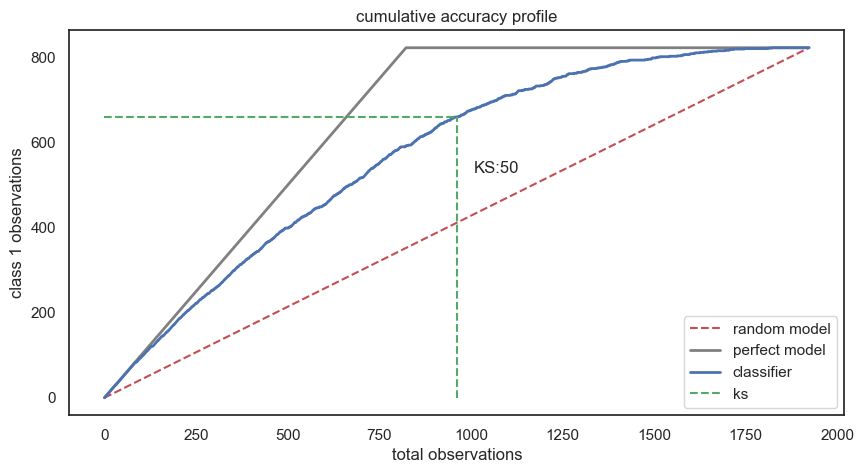

,bin,count_of_rows,total_target,model_percent,random_percent,model_cumm_percent,random_cumm_percent,ks
0,0,0,0,0.00,0,0.00,0,0.00
1,1,192,174,21.14,10,21.14,10,11.14
2,2,192,148,17.98,10,39.12,20,19.12
3,3,192,123,14.95,10,54.07,30,24.07
4,4,192,118,14.34,10,68.41,40,28.41
5,5,192,97,11.79,10,80.20,50,30.20
6,6,192,65,7.90,10,88.10,60,28.10
7,7,192,50,6.08,10,94.18,70,24.18
8,8,192,27,3.28,10,97.46,80,17.46
9,9,192,18,2.19,10,99.65,90,9.65


In [91]:
Metrics.generate_cap_curve_and_table(
    df=results,
    target='SAT_Target',
    y=y_test,
    y_score=proba,
    ks=50,
    text='KS:50',
    font=1,
    width=10,
    length=5,
)

Given Intel's potential interest in reaching out to **unsatisfied customers**, the **Cumulative Accuracy Profile (CAP) curve** and **Kolmogorov-Smirnov (KS) score** were calculated to assess the model's effectiveness.  

As shown above, the model correctly identifies **80% of true positives** within the first **five deciles** when predictive probabilities are sorted from highest to lowest. Compared to a random model (50%), this represents a **30% improvement**, demonstrating that the model is **1.6 times more effective** at predicting true positives than random chance.  

This peak performance at the fifth decile highlights the model's **efficiency in filtering true positives**, as such, Intel could reliably **proactively engage these customers for future surveys, promotions, and targeted outreach**.  

### Model Finalization

In [94]:
# Prepare your text data and target from the training DataFrame
X_data = doc['processed_MTranslation2']
y_data = doc['SAT_Target']

# Vectorize and convert the full training set
X_data = vectorizer.transform(X_data)
logit_model = logit_model.fit(X_data, y_data)
y_pred = logit_model.predict(X_data)
print("\nFinal Classification Report on Full Data:\n", classification_report(y_data, y_pred))


Final Classification Report on Full Data:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89      3666
           1       0.83      0.91      0.87      2743

    accuracy                           0.88      6409
   macro avg       0.88      0.88      0.88      6409
weighted avg       0.88      0.88      0.88      6409



As observed in both the training and testing phases, the model **significantly improves** when trained on the **full dataset**.  

This suggests that while the model demonstrates **moderate generalization** on unseen data, its performance benefits greatly from additional training data, reinforcing the potential for further improvements with larger training datasets.  

In [98]:
# Save the model
dump(logit_model, open(r"Models/Intel_Satisfaction_Classifier.pkl", 'wb'))

In [100]:
# load the model
logit_model = load(open(r"Models/Intel_Satisfaction_Classifier.pkl", 'rb'))

In [104]:
# Save the model
dump(vectorizer, open(r"Models/Intel_Satisfaction_Vectorizer.pkl", 'wb'))

In [106]:
# load the model
vectorizer = load(open(r"Models/Intel_Satisfaction_Vectorizer.pkl", 'rb'))

In [215]:
# Define the class names in the correct order based on the model's class mapping.
class_names = ['dissatisfied', 'satisfied']
explainer = LimeTextExplainer(class_names=class_names)


# Define a prediction function that takes a list of texts and returns prediction probabilities.
def predict_proba(texts: List[str]) -> np.ndarray:
    """
    Predicts the probability of each class for a given list of text inputs 
    using a pre-trained logistic regression model.

    Args:
        texts (List[str]): A list of text inputs to classify.

    Returns:
        np.ndarray: A 2D NumPy array where each row corresponds to a text input 
                    and contains the predicted probabilities for each class.
    """
    # Transform text inputs into feature vectors using the pre-trained vectorizer
    X = vectorizer.transform(texts)

    # Predict class probabilities using the trained logistic regression model
    return logit_model.predict_proba(X)


# Explain a Sample Review in Real Time
text_instance = """
The wait time was unacceptable and I felt ignored by the representative."
"""

# Get the explanation for the review.
exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)

# Print the explanation as a list of (word, weight) tuples.
print("LIME Explanation (word contributions):")
print(exp.as_list())


# Function to highlight words based on their contribution
def highlight_text(text: str, exp_list: List[Tuple[str, float]]) -> str:
    """
    Highlights influential words in the given text based on LIME explanations.

    - Words contributing to **dissatisfaction** (class index 1) are highlighted in **red**.
    - Words contributing to **satisfaction** (class index 0) are highlighted in **green**.

    Args:
        text (str): The original input text to be analyzed.
        exp_list (List[Tuple[str, float]]): A list of tuples where each tuple contains:
            - A word (str) from the text.
            - A weight (float) representing its contribution to the predicted sentiment.

    Returns:
        str: An HTML-formatted string with highlighted influential words.
    """
    
    # Create a dictionary from the LIME explanation mapping words to their importance weights
    word_weights = {word.lower(): weight for word, weight in exp_list}

    # Split the original text into individual words
    words = text.split()
    highlighted_words = []

    for word in words:
        # Preprocess word: remove punctuation, normalize, and lowercase for matching
        word_clean = re.sub(r"[^a-zA-Z0-9\s]", "", word).strip().lower()

        # Check if the cleaned word exists in LIME's explanation list
        if word_clean in word_weights:
            weight = word_weights[word_clean]

            # Corrected Logic:
            # - **Positive weight → contributes to 'dissatisfied' → RED**
            # - **Negative weight → contributes to 'satisfied' → GREEN**
            color = 'red' if weight > 0 else None

            # Apply HTML styling to highlight the word
            highlighted_word = f'<span style="background-color:{color}; padding: 2px;">{word}</span>'
        else:
            highlighted_word = word  # Keep the word unchanged if it has no associated weight

        highlighted_words.append(highlighted_word)

    # Reconstruct and return the formatted HTML string with highlighted words
    return " ".join(highlighted_words)


# Generate HTML highlighting for the sample review.
exp_list = exp.as_list()
highlighted_html = highlight_text(text_instance, exp_list)

# Display the highlighted text
from IPython.core.display import display, HTML
display(HTML(f"<div style='font-size: 16px;'>{highlighted_html}</div>"))

LIME Explanation (word contributions):
[('unacceptable', 0.30814888656000905), ('felt', -0.12240745102158618), ('wait', 0.07543270268527044), ('representative', 0.05685124240159687), ('time', -0.037160443402902046), ('and', 0.001961491009548365), ('was', 0.0019597296222028083), ('ignored', 0.0010396305097990532), ('by', -0.0007063106003420198), ('the', -0.0006055890507425685)]


As this model evolves in predicting and understanding customer satisfaction from reviews, tools like the above could be **leveraged in real-time** to assist call center representatives in improving service quality, ultimately increasing customer satisfaction.  

The function above utilizes **Local Interpretable Model-agnostic Explanations (LIME)**, which—if further developed—could provide **real-time insights** into customer sentiment during live conversations. Words highlighted in **red** indicate **expressions of dissatisfaction**, as identified by the model, allowing representatives to proactively adjust their approach and enhance customer experience.  
